In [1]:
# Necessary imports
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

## 1 Download/Load SP500 stocks prices data.

In [2]:
# Download the SP500 companies from Wiki
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500["Symbol"] = sp500["Symbol"].str.replace(".","-")
symbol_list = sp500["Symbol"].unique().tolist()

#Download yahoo finance data (last 8 years)
end_date = "2024-03-31"
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers=symbol_list,
                 start=start_date,
                 end=end_date)

# Data Cleaning
df = df.stack()
df.index.names = ["date","ticker"]
df.columns = df.columns.str.lower()
df

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1459569600, endDate = 1711857600")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-04 A        37.544670   40.009998   40.520000   39.799999   40.320000   
           AAL      37.726421   39.369999   40.240002   39.150002   39.810001   
           AAPL     25.395550   27.780001   28.047501   27.567499   27.605000   
           ABBV     41.949997   59.209999   59.400002   57.490002   57.639999   
           ABT      36.484840   42.320000   42.669998   42.160000   42.340000   
...                       ...         ...         ...         ...         ...   
2024-03-28 XYL     129.240005  129.240005  130.220001  129.149994  129.559998   
           YUM     138.649994  138.649994  138.830002  137.389999  137.389999   
           ZBH     131.979996  131.979996  133.899994  131.600006  132.929993   
           ZBRA    301.440002  301.440002  302.630005  298.040009  300.239990   
           ZTS     169.210007  169.210007  171.139999  167.410004  168.729996   

Price                   volume  
date       ticker               
2016-04-04 A         2958100.0  
           AAL       7831200.0  
           AAPL    149424800.0  
           ABBV      8108100.0  
           ABT       4407800.0  
...                        ...  
2024-03-28 XYL        953200.0  
           YUM       1770900.0  
           ZBH       1425300.0  
           ZBRA       376900.0  
           ZTS       3395600.0  

[991223 rows x 6 columns]

## 2 Calculate technical inticators

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [3]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-04 A        37.544670   40.009998   40.520000   39.799999   40.320000   
           AAL      37.726421   39.369999   40.240002   39.150002   39.810001   
           AAPL     25.395550   27.780001   28.047501   27.567499   27.605000   
           ABBV     41.949997   59.209999   59.400002   57.490002   57.639999   
           ABT      36.484840   42.320000   42.669998   42.160000   42.340000   
...                       ...         ...         ...         ...         ...   
2024-03-28 XYL     129.240005  129.240005  130.220001  129.149994  129.559998   
           YUM     138.649994  138.649994  138.830002  137.389999  137.389999   
           ZBH     131.979996  131.979996  133.899994  131.600006  132.929993   
           ZBRA    301.440002  301.440002  302.630005  298.040009  300.239990   
           ZTS     169.210007  169.210007  171.139999  167.410004  168.729996   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-04-04 A         2958100.0         -0.001804        NaN       NaN   
           AAL       7831200.0         -0.000739        NaN       NaN   
           AAPL    149424800.0         -0.002539        NaN       NaN   
           ABBV      8108100.0         -0.038465        NaN       NaN   
           ABT       4407800.0         -0.008485        NaN       NaN   
...                        ...               ...        ...       ...   
2024-03-28 XYL        953200.0          0.000032  64.013537  4.842979   
           YUM       1770900.0          0.000022  58.411406  4.908242   
           ZBH       1425300.0          0.000130  64.609399  4.818202   
           ZBRA       376900.0          0.000111  62.620998  5.629442   
           ZTS       3395600.0          0.000240  36.439484  5.091852   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-04-04 A            NaN       NaN       NaN       NaN     111.060889  
           AAL          NaN       NaN       NaN       NaN     295.443151  
           AAPL         NaN       NaN       NaN       NaN    3794.724946  
           ABBV         NaN       NaN       NaN       NaN     340.134770  
           ABT          NaN       NaN       NaN       NaN     160.817879  
...                     ...       ...       ...       ...            ...  
2024-03-28 XYL     4.859159  4.875340 -0.272662  0.832538     123.191573  
           YUM     4.932814  4.957387 -0.044518  0.120086     245.535274  
           ZBH     4.850913  4.883624 -0.655308  0.537839     188.111088  
           ZBRA    5.668904  5.708366  0.016500  0.823688     113.612737  
           ZTS     5.175743  5.259635  0.908825 -2.766863     574.569499  

[991223 rows x 14 columns]

## 3 Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [4]:
# To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

# Calculate 5-year rolling average of dollar volume for each stocks before filtering.
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

## 4 Calculate Monthly Returns for different time horizons as features.

In [5]:
# To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag),
# that is, returns over various monthly periods as identified by lags.

def calculate_returns(df):
    
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m']= (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-04-30 AAL      41.922878  2.133559  3.961549  3.733074  3.847312   
           AAPL     39.177345 -0.818114  3.777232  3.663645  3.720439   
           ABBV     74.159782  0.982471  4.331109  4.229163  4.280136   
           ABT      52.741093 -0.565441  4.019137  3.974422  3.996780   
           ACN     138.647690 -0.516886  4.969163  4.904240  4.936702   
...                       ...       ...       ...       ...       ...   
2024-03-31 WMT      60.169998  0.169386  4.141587  4.095753  4.118670   
           XOM     116.239998 -0.052811  4.776569  4.653202  4.714886   
           MRNA    106.559998 -0.427977  4.748112  4.557914  4.653013   
           UBER     76.989998  1.020126  4.412530  4.338960  4.375745   
           ABNB    164.960007 -0.861182  5.142737  5.070103  5.106420   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-04-30 AAL            -0.000233 -2.451371  34.064548  -0.173788   
           AAPL            0.000096 -0.519765  44.093201  -0.015020   
           ABBV           -0.031916 -0.927851  47.693750   0.030640   
           ABT            -0.005614 -0.418466  45.310083  -0.025203   
           ACN            -0.003740 -0.329597  47.986151  -0.006292   
...                             ...       ...        ...        ...   
2024-03-31 WMT             0.000025  1.279481  58.957218   0.030113   
           XOM             0.000058  2.267394  73.762481   0.112132   
           MRNA            0.000869  0.272863  55.121904   0.155247   
           UBER            0.000058  0.530637  53.539456  -0.031572   
           ABNB            0.000105  0.753148  57.961730   0.047565   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-04-30 AAL     -0.110429  -0.074851  -0.013677  -0.017083    0.001295  
           AAPL    -0.036775  -0.002988  -0.002490   0.013081    0.013071  
           ABBV    -0.082295  -0.045625   0.014256   0.039338    0.035160  
           ABT     -0.016043  -0.020529   0.013257   0.020388    0.025886  
           ACN     -0.026677  -0.017233   0.011571   0.020044    0.020096  
...                      ...        ...        ...        ...         ...  
2024-03-31 WMT      0.046931   0.047357   0.021589   0.016699    0.018226  
           XOM      0.068240   0.054759   0.001149   0.011961    0.007816  
           MRNA     0.026902   0.023285   0.005208  -0.014473   -0.030000  
           UBER     0.086076   0.077346   0.089670   0.066392    0.076749  
           ABNB     0.069786   0.066099   0.031174   0.028444    0.023795  

[10359 rows x 14 columns]

## 5 Download Fama-French Factors and Calculate Rolling Factor Betas.

In [6]:
# Fama—French data are used to estimate the exposure of assets to common risk factors using linear regression.
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

# Filter out stocks with less than 10 months of data.
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

# Calculate Rolling Factor Betas.
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

#Join the rolling factors data to the main features dataframe.
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)
data = data.dropna()
data.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10196 entries, (Timestamp('2018-04-30 00:00:00'), 'AAL') to (Timestamp('2024-03-31 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10196 non-null  float64
 1   bb_high           10196 non-null  float64
 2   bb_low            10196 non-null  float64
 3   bb_mid            10196 non-null  float64
 4   garman_klass_vol  10196 non-null  float64
 5   macd              10196 non-null  float64
 6   rsi               10196 non-null  float64
 7   return_1m         10196 non-null  float64
 8   return_2m         10196 non-null  float64
 9   return_3m         10196 non-null  float64
 10  return_6m         10196 non-null  float64
 11  return_9m         10196 non-null  float64
 12  return_12m        10196 non-null  float64
 13  Mkt-RF            10196 non-null  float64
 14  SMB               10196 non-null  float64
 15  HML       

## 6 For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

In [7]:
from sklearn.cluster import KMeans

# Apply pre-defined centroids.
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values
initial_centroids

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-04-30 AAL     2.133559  3.961549  3.733074  3.847312         -0.000233   
           AAPL   -0.818114  3.777232  3.663645  3.720439          0.000096   
           ABBV    0.982471  4.331109  4.229163  4.280136         -0.031916   
           ABT    -0.565441  4.019137  3.974422  3.996780         -0.005614   
           ACN    -0.516886  4.969163  4.904240  4.936702         -0.003740   
...                     ...       ...       ...       ...               ...   
2024-03-31 WFC    -0.341665  4.086067  4.038277  4.062172          0.000030   
           WMT     0.169386  4.141587  4.095753  4.118670          0.000025   
           XOM    -0.052811  4.776569  4.653202  4.714886          0.000058   
           MRNA   -0.427977  4.748112  4.557914  4.653013          0.000869   
           UBER    1.020126  4.412530  4.338960  4.375745          0.000058   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-04-30 AAL    -2.451371  34.064548  -0.173788  -0.110429  -0.074851   
           AAPL   -0.519765  44.093201  -0.015020  -0.036775  -0.002988   
           ABBV   -0.927851  47.693750   0.030640  -0.082295  -0.045625   
           ABT    -0.418466  45.310083  -0.025203  -0.016043  -0.020529   
           ACN    -0.329597  47.986151  -0.006292  -0.026677  -0.017233   
...                     ...        ...        ...        ...        ...   
2024-03-31 WFC     1.296821  67.497281   0.042634   0.078496   0.058463   
           WMT     1.279481  58.957218   0.030113   0.046931   0.047357   
           XOM     2.267394  73.762481   0.112132   0.068240   0.054759   
           MRNA    0.272863  55.121904   0.155247   0.026902   0.023285   
           UBER    0.530637  53.539456  -0.031572   0.086076   0.077346   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-04-30 AAL     -0.013677  -0.017083    0.001295  1.235900  1.410526   
           AAPL    -0.002490   0.013081    0.013071  1.323462 -0.361470   
           ABBV     0.014256   0.039338    0.035160  0.456440  0.554797   
           ABT      0.013257   0.020388    0.025886  0.807434 -0.145253   
           ACN      0.011571   0.020044    0.020096  1.221949 -0.177675   
...                      ...        ...         ...       ...       ...   
2024-03-31 WFC      0.062806   0.037311    0.039950  1.066638 -0.078570   
           WMT      0.021589   0.016699    0.018226  0.602102 -0.413935   
           XOM      0.001149   0.011961    0.007816  1.099403  0.211392   
           MRNA     0.005208  -0.014473   -0.030000  1.350171  0.626332   
           UBER     0.089670   0.066392    0.076749  1.116533  0.997055   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-04-30 AAL     0.485002  0.136368  0.795778        0  
           AAPL   -0.620854  0.463613  0.619540        1  
           ABBV   -0.170330  0.516959  0.383818        1  
           ABT    -0.479459  0.278422  0.966951        1  
           ACN    -0.279906  0.316984  0.140965        1  
...                     ...       ...       ...      ...  
2024-03-31 WFC     1.536677 -0.743295 -0.771875        3  
           WMT    -0.351971  0.274736  0.690452        2  
           XOM     0.777691 -0.472599  0.524177        3  
           MRNA   -1.245496  0.907694  1.026666        1  
           UBER   -0.279137 -1.443168 -0.436184        1  

[10196 rows x 19 columns]

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization


In [8]:
# First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.
# Momentum is persistent and our idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month.
# Thus we would select stocks corresponding to cluster 3.
filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()


# Define portfolio optimization function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()
    
# Download Fresh Daily Prices Data only for short listed stocks.
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  157 of 157 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-05-01  40.753750   34.207817   49.388069   38.669182  109.154350   
2017-05-02  42.487328   34.424870   49.499508   38.775894  108.641212   
2017-05-03  42.535748   34.319843   49.581242   38.882618  108.299103   
2017-05-04  42.526066   34.196152   49.945271   39.656364  108.767258   
2017-05-05  43.107151   34.763256   49.766956   39.700825  109.397408   
...               ...         ...         ...         ...         ...   
2024-03-22  14.820000  172.279999  178.449997  110.570000  336.198242   
2024-03-25  14.920000  170.850006  178.529999  110.010002  332.532440   
2024-03-26  14.920000  169.710007  179.190002  111.500000  335.092529   
2024-03-27  15.300000  173.309998  180.350006  113.480003  339.624969   
2024-03-28  15.350000  171.479996  182.100006  113.660004  345.273071   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-05-01  135.110001   89.700409   91.980003  51.175201   38.453987  ...   
2017-05-02  135.000000   89.734917   93.449997  51.108746   38.463211  ...   
2017-05-03  134.850006   84.127029   93.349998  51.117050   38.315662  ...   
2017-05-04  134.610001   85.498810   93.250000  52.055660   38.380219  ...   
2017-05-05  134.839996   85.662712   93.239998  52.088898   38.573872  ...   
...                ...         ...         ...        ...         ...  ...   
2024-03-22  499.519989  247.610001  262.859985  76.379997  210.250000  ...   
2024-03-25  507.230011  244.199997  261.570007  76.589996  208.460007  ...   
2024-03-26  507.600006  245.070007  261.670013  77.389999  206.669998  ...   
2024-03-27  504.399994  248.330002  260.970001  78.339996  208.000000  ...   
2024-03-28  504.600006  249.740005  260.420013  78.169998  206.229996  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-05-01   9042100  5432900  2108800  14455200   3380000   8368400   
2017-05-02  11627700  4476300  2465400  13397800   4013900   4849300   
2017-05-03   4909000  2993300  1333300  19568100   3288400   4382100   
2017-05-04   5257000  3068300  1672700  20767700   3561500   3337800   
2017-05-05   8844500  4668900  2545100  17133000   4187100   3057000   
...              ...      ...      ...       ...       ...       ...   
2024-03-22   8743000  3497100   821700  17815600   8219000   5438700   
2024-03-25   8519200  2767900   732800  14587200  10464100   6259000   
2024-03-26   8752400  3025300   952400  17854100  10183300  11428900   
2024-03-27   5190700  3098600   905400  19260100  12394400   6283200   
2024-03-28   5844400  3325900  1092100  19771400  32886800   7935600   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-05-01  13915800  18497700  2138700   8664100  
2017-05-02  15634900  21955200  1497500   9102900  
2017-05-03  15737100  16570800  1322800  10289000  
2017-05-04  17054100  16502400  1423300  16164500  
2017-05-05  13078800  16793400  3086100  10213000  
...              ...       ...      ...       ...  
2024-03-22  13736200  14025400   899600  14695400  
2024-03-25  15028200  14186600  1238100  14011700  
2024-03-26  11445900  13738300   959100  13152300  
2024-03-27  13762800  14363400  1090200  12415700  
2024-03-28  14619000  17535100  1018200  18482100  

[1740 rows x 942 columns]

In [9]:
#  Calculate daily returns for each stock which could land up in our portfolio.
#  Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
#  If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.
#  Calculated each day portfolio return.

returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"


,Strategy Return
date,
2018-05-01,-0.003928
2018-05-02,-0.002984
2018-05-03,-0.002474
2018-05-04,0.005639
2018-05-07,-0.001313
...,...
2024-03-22,-0.000770
2024-03-25,-0.001821
2024-03-26,-0.002517


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [10]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-05-01,-0.003928,0.001775
2018-05-02,-0.002984,-0.006740
2018-05-03,-0.002474,-0.002206
2018-05-04,0.005639,0.012863
2018-05-07,-0.001313,0.003378
...,...,...
2024-03-22,-0.000770,-0.001898
2024-03-25,-0.001821,-0.002767
2024-03-26,-0.002517,-0.001849
2024-03-27,0.003158,0.008369


## 9. Visualization

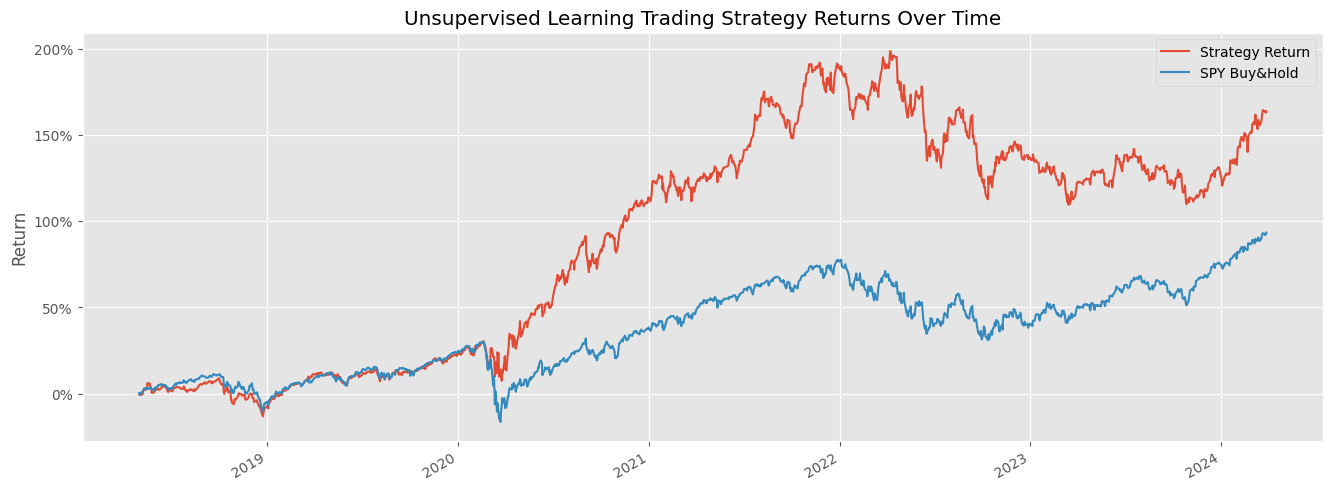

In [11]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:"2024-03-31"].plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()